<a href="https://colab.research.google.com/github/claudia-viaro/optimal_switching/blob/main/LSPI_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Least Square Policy Iteration

<a href="https://www.jmlr.org/papers/volume4/lagoudakis03a/lagoudakis03a.pdf">Lagoudakis (2003)</a>


In [91]:
'''
this is not using gym
uses same idea behind the Jentzen's paper

'''

"\nthis is not using gym\nuses same idea behind the Jentzen's paper\n\n"

In [92]:
import math, time
import numpy as np
import copy

from itertools import combinations

import torch
import torch.nn as nn
np.random.seed(234198)
import itertools
import random

import scipy.stats


import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as tdata

A policy $\pi$ is a behavior function that maps states to actions:
\begin{equation}
a = \pi(s)
\end{equation}

If we consider a full episode (one of our complete trajectories) that starts at time t=0 and terminates at time t=T, then we define the return R₀ from the starting state as:

\begin{equation}
R_0 = \sum_{t=0}^T \gamma^t r_t
\end{equation}
Where $r_t$ is the reward at time $=t$, and $\gamma$ is a discount factor in the range $[0,1]$, which allows us to adjust the time horizon, and ensure the return over long episodes remains finite. 

As the transition from state $s \rightarrow s^{\prime}$ is generally probabilistic (starting multiple episodes from the same state will generally result in different returns), we take the expectation value of return over all allowed trajectories. By doing so, we can define the expected return, called the state-value function $V_{\pi}$ which describes the expected return starting from state $s$ and then following policy $\pi$:

\begin{equation}
V_{\pi} =  \mathbb{E}[R_t | s_t = s_t] 
\end{equation}
where $R_t$ is the return of a single, specific full episode starting at time $t$. The expectation operator $\mathbb{E}[\cdot]$ averages over all possible individual episodes/trajectories starting from initial state $s$ and following policy $\pi$. 

A closely related quantity is the action-value function $Q_{\pi}$ which describes the expected return starting in state $s$, taking action $a$, and thereafter following policy $\pi$:

\begin{equation}
Q_{\pi}(s,a) =  \mathbb{E}_{a_t \sim \pi; s_t \sim \mathcal{P}}[R_0 | s_0 = s, a_0 = a] 
\end{equation}

In most scenarios, the underlying MDP model is not fully available. Typically, the state space, the action space, and the discount factor are available, whereas the transition model and the reward function are not known in advance. It is still desirable to be able to evaluate, or, even better, find good decision policies. Here we rely on information that comes from interaction between the decision maker and the process itself, hence tuples known as samples: 
\begin{equation}
(s, a, r, s^{\prime})
\end{equation}
Samples are collected from actual (sequential) episodes of interaction with the processand the algorithm learns decision policies from such samples.

### Approximation
In our algorithm, we approximate the action-value function $Q_{\pi}(s, a)$ by a linear architecture and its actual representation consists of a compact
description of the basis functions and a set of parameters. 



## Action-value function approximation

Let $\hat{Q}_{\pi}(s,a; w)$ be an approximation to $Q_{\pi}(s,a)$ represented by a parametric approximation architecture with free parameters $w$. 

The main idea of value-function approximation is that the parameters $w$ can be adjusted appropriately so that the approximate values are “close enough” to the original values, and, therefore, $\hat{Q}_{\pi}$ can be used in place of the exact value function $Q_{\pi}$.

LSPI is only one particular example of the family of reinforcement-learning algorithms for control based on approximate policy iteration. It distinguishes itself on the basis of choices related to:
- approximation architecture (linear)
- policy evaluation and projection procedure (LSTD$Q$). These two steps are merged together because the target function $Q_{\pi}$ is not known in
advance, and must be inferred from the observed system dynamics. It is not possible to use a training set of examples of the form $\{(s,a), Q_{\pi}(s,a)  \}$ that provide the value $ Q_{\pi}(s,a)$ of the target function at certain sample points $(s,a)$.


### Appriximation architecture
$Q_{\pi}$ values are approximated by a linear parametric combination of
$k$ basis functions (features):
\begin{equation}
\hat{Q}_{\pi}(s,a; w) = \sum_{j=1}^k \phi_j (s,a) w_j
\end{equation}

where the $w_j$’s are the parameters. The basis functions $\phi_j (s,a)$ are fixed, but arbitrary and, in general, non-linear, functions of $s$ and $a$. We require that the basis functions $\phi_j$ are linearly independent to ensure that there are no redundant parameters and that the matrices involved in the computations are full rank. Typical linear approximation architectures are polynomials of any degree (each basis function is a polynomial term) and
radial basis functions (each basis function is a Gaussian with fixed mean and variance).

Define $\phi(s,a)$ to be the column vector of size $k$ where each entry $j$ is the corresponding basis function $\phi_j$ computed at $(s,a)$:
\begin{align}
\phi(s,a) =
 \begin{pmatrix}
  \phi_1(s,a) \\
  \ldots \\
  \phi_k(s,a) 
 \end{pmatrix}
\end{align}

Now, $\hat{Q}_{\pi}$ can be expressed compactly as $\hat{Q}^{\pi} = \mathbf{\Phi}w^{\pi}$, where $w^{\pi}$ is a column vector of length $k$ with all parameters and $\mathbf{\Phi}$ is a $(|\mathcal{S}||\mathcal{A}| × k)$ matrix, where each row contains the value of all basis functions for a certain pair $(s,a)$ and each column the value of a certain basis function for all pairs $(s,a)$.

### LSTD$Q$

Consider the problem of learning the (weighted) least-squares fixed-point approximation $\hat{Q}_{\pi}$ to the state-action value function $Q_{\pi}$ of a fixed policy $\pi$ from samples. Assuming that there are $k$ linearly independent basis functions in the linear architecture, this problem is
equivalent to learning the parameters $w^{\pi}$ of $\hat{Q}_{\pi} = \mathbf{\Phi}w^{\pi}$. The exact values for $w^{\pi}$ can be computed from the model by solving the $(k × k)$ linear system:

\begin{equation}
\mathbf{A} w^{\pi}= b,
\end{equation}
where
\begin{equation}
\mathbf{A} = \mathbf{\Phi}^\intercal \Delta_{\mu} (\mathbf{\Phi} − \gamma \mathbf{P} \mathbf{\Pi}_{\pi} \mathbf{\Phi})\;\;\;\; \text{and} \;\;\;\; b =\mathbf{\Phi}^\intercal \Delta_{\mu} \mathcal{R} ,
\end{equation}
and $\mu$ is a probability distribution over $S × A)$ that defines the weights of the projection.

For the learning problem, $\mathbf{A}$ and $b$ cannot be determined a priori, either because the matrix $\mathbf{P}$ and the vector $\mathcal{R}$ are unknown, or because they are so large that they cannot be used in any practical computation. However, $\mathbf{A}$ and $b$ can be learned using samples; the
learned linear system can then be solved to yield the learned parameters we
$\pi$ which, in turn, determine the learned value function.

So, given any finite set of $L$ samples:
\begin{equation}
D = \Big\{(s_i, a_i, r_i, s^{\prime}_i), i =1, \ldots, L     \Big\}
\end{equation}

then we can compute $\mathbf{A}$ and b as:

\begin{equation}
\tilde{\mathbf{A}} = \frac{1}{L} \sum_{i=1}^L \Bigg[\phi(s_i, a_i) \Big(\phi(s_i, a_i) - \gamma \phi(s_i^{\prime}, \pi(s_i^{\prime} )   \Big)^{\intercal} \Bigg]\\
\tilde{b} = \frac{1}{L} \sum_{i=1}^L  \Bigg[\phi(s_i, a_i) r_i \Bigg]
\end{equation}
assuming that the distribution $\mu_{D}$ of the samples in $D$ over $(\mathcal{S} \times \mathcal{A})$ matches the desired distribution. Clearly, the learned approximation is biased by the distribution $\mu_{D}$ of samples. In general, the distribution $\mu_{D}$ might be different from the desired distribution $\mu$. This problem would be resolved trivially when a generative model is available, since samples can be drawn so that $\mu_{D} = \mu$.


Given that a single sample contributes to $\tilde{\mathbf{A}}$ and $\tilde{b}$ additively, it is easy to construct an incremental update rule for these. Let $\tilde{\mathbf{A}}^{(t)}$ and $\tilde{b}^{(t)}$ be the current learned estimates of $\mathbf{A}$ and $b$ for a fixed policy $\pi$, assuming that initially $\tilde{\mathbf{A}}^{(0)} = 0$ and $\tilde{b}^{(0)} = 0$. A new sample
$(s_t, a_t, r_t,s^{\prime}_t)$ contributes to the approximation according to the following update equations:

\begin{equation}
\tilde{\mathbf{A}}^{t+1} = \tilde{\mathbf{A}}^{t} + \phi(s_i, a_i) \Big(\phi(s_i, a_i) - \gamma \phi(s_i^{\prime}, \pi(s_i^{\prime} )   \Big)^{\intercal}\\
\tilde{b}^{t+1} = \tilde{b}^{\prime} + \phi(s_i, a_i) r_i 
\end{equation}

From these results we can then proceed to learn the weighted least-squares
fixed-point approximation of the state-action value function of a fixed policy $\pi$ from samples in a batch or in an incremental way.

### Back to RL
At this point we have an approximated state-value function $\hat{Q}_{\pi}$:
\begin{equation}
\hat{Q}_{\pi}(s,a; w) = \sum_{j=1}^k \phi_j (s,a) w_j = \phi(s,a)^{\intercal}w
\end{equation}
The greedy policy $\pi$ over this approximate value function at any given state $s$ can be obtained through maximization of the approximate values over all actions in $\mathcal{A}$.

\begin{equation}
\pi(s) =  \arg \max_{a \in \mathcal{A}} \hat{Q}_{\pi}(s,a) = \arg \max_{a \in \mathcal{A}} \phi(s,a)^{\intercal}w
\end{equation}

In [93]:
class BlackScholes:
  def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, strike, dividend=0):

    self.drift = drift - dividend
    self.sigma = sigma
    self.delta = delta
    self.spot = spot
    self.assets = assets
    self.paths = paths
    self.periods = periods
    self.maturity = maturity
    self.strike = strike
    self.dt = self.maturity / self.periods
    self.df = math.exp(-self.drift * self.dt)

  def drift_fct(self, x, t):
    del t
    return self.drift * x

  def diffusion_fct(self, x, t, v=0):
    del t
    return self.sigma * x



  def generate_paths(self):
    """Returns a nparray (nb_paths * assets * nb_dates) with prices."""
    paths = self.paths
    spot_paths = np.empty((paths, self.assets, self.periods+1))
    spot_paths[:, :, 0] = self.spot
    random_numbers = np.random.normal(
        0, 1, (paths, self.assets, self.periods))
    dW = random_numbers * np.sqrt(self.dt)
    drift = self.drift
    r = np.repeat(np.repeat(np.repeat(
        np.reshape(drift, (-1, 1, 1)), paths, axis=0),
        self.assets, axis=1), self.periods, axis=2)
    sig = np.repeat(np.repeat(np.repeat(
        np.reshape(self.sigma, (-1, 1, 1)), paths, axis=0),
        self.assets, axis=1), self.periods, axis=2)
    spot_paths[:, :,  1:] = np.repeat(
        spot_paths[:, :, 0:1], self.periods, axis=2) * np.exp(np.cumsum(
        (r-self.delta) * self.dt - (sig ** 2) * self.dt / 2 + sig * dW, axis=2))
    # dimensions: [nb_paths, assets, periods+1]

    return spot_paths

(5000, 20, 10)
(5000, 20, 10)


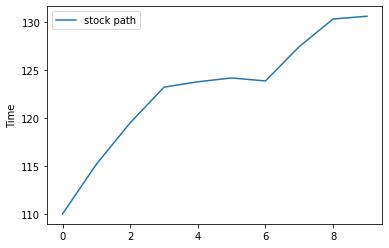

[110.         115.17256211 119.48101085 123.19125495 123.74954965
 124.14983633 123.83941777 127.41153067 130.28531432 130.571288  ]


In [94]:
# generate underlying stochastic process

hyperparam_test_stock_models = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':5000, 'periods': 9, 'maturity': 3., 'strike' : 100,'assets':20,  'spot':110,}
#S = GBM(**hyperparam_test_stock_models)
#X=S.simulate_process()


S=BlackScholes(**hyperparam_test_stock_models)
X=S.generate_paths()
print(X.shape) # (date, path, asset)   (original: paths, stocks, dates)

print(X.shape)
def draw_stock_model(stockmodel):
    stock_paths = stockmodel

    # draw a path
    one_path = stock_paths[0, 0, :]
    dates = np.array([i for i in range(len(one_path))])
    plt.plot(dates, one_path, label='stock path')
    plt.ylabel('Stock price')
    plt.ylabel('Time')
    plt.legend()
    return plt.show()   

draw_stock_model(X) 

print(X[0, 0, :])

In [95]:
# basis functions

class BasisFunctions:
    def __init__(self, nb_stocks):
        self.nb_stocks = nb_stocks
        lst = list(range(self.nb_stocks))
        self.combs =  [list(x) for x in combinations(lst, 2)] # all combinations of assets in pairs. e.g. [0,1], [0,2], ...
        self.nb_base_fcts = 1 + 2 * self.nb_stocks + len(self.combs) # 66
        # print("self.nb_base_fcts", self.nb_base_fcts)
        # print("nb_stocks",  self.nb_stocks)

    def base_fct(self, i, x):
        bf=np.nan
        if (i == 0):
            bf = np.ones_like(x[0]) # (constant)
        elif (i <= self.nb_stocks):
            bf = x[i-1] # (x1, x2, ..., xn)
        elif (self.nb_stocks < i <= 2 * self.nb_stocks):
            k = i - self.nb_stocks - 1
            bf = x[k] ** 2 # (x1^2, x2^2, ..., xn^2)
        elif (i > 2 * self.nb_stocks):
            k = i - 2*self.nb_stocks -1
            bf = x[self.combs[k][0]] * x[self.combs[k][1]] # (x1x2, ..., xn-1xn)
        return bf

In [96]:
'''
PAYOFF
'''

# Payoff
class Payoff:
  def __init__(self, model):
    self.strike = model.strike

  def MaxCall(self, X):
    payoff = np.max(X, axis = 1) - self.strike
    return payoff.clip(0, None)

  def MaxPut(self, X):
    payoff = self.strike - np.max(X, axis=1)
    return payoff.clip(0, None)   


  def GeometricPut(self, X):
    dim = len(X[1])  
    payoff = self.strike - np.prod(X, axis=1) ** (1/dim)
    return payoff.clip(0, None)


In [97]:
class LeastSquarePI:
  def __init__(self, model, payoff, epochs=20):
    self.model = model
    self.payoff = payoff(self.model)
    self.epochs = epochs
    #self.nb_base_fcts = 0
    self.bf = BasisFunctions(self.model.assets*(1) + 2)
    self.nb_base_fcts = self.bf.nb_base_fcts # (?)

  def get_indicator_stop(self, payoff, continuation_value):
    return payoff if payoff > continuation_value else 0


  def get_contribution_u(self, payoff, evaluated_bases, next_evaluated_bases, discount_factor, continuation_value):
    nb_base_fcts = len(evaluated_bases)
    indicator_continue = (next_evaluated_bases if payoff < continuation_value
                          else np.zeros(nb_base_fcts, dtype=float))
    return np.outer(evaluated_bases, evaluated_bases - discount_factor * indicator_continue)
 
  def evaluate_bases(self, stock_price, path, date, nb_dates):
      time = date/nb_dates
      stock_price_path_date = np.concatenate([stock_price[path, :, date], np.array([time, 1 - time])])
      return np.array([self.bf.base_fct(i, stock_price_path_date)
                        for i in range(self.bf.nb_base_fcts)])

  def price(self):

    stock_paths = self.model.generate_paths()
    payoffs = self.payoff.MaxCall(stock_paths)
    stock_paths_with_payoff = np.concatenate([stock_paths, np.expand_dims(payoffs, axis=1)], axis=1)
    

    matrixA = np.zeros((self.nb_base_fcts, self.nb_base_fcts), dtype=float)
    vectorb = np.zeros(self.nb_base_fcts, dtype=float)
    weights = np.zeros(self.nb_base_fcts, dtype=float)
    deltaT = self.model.maturity / (self.model.periods + 1)
    discount_factor = math.exp(-self.model.drift * deltaT)
    paths = stock_paths
    
    for epoch in range(self.epochs):
      for i_path, path in enumerate(range(self.model.paths)):
        for date in range(self.model.periods):
          payoff = self.payoff.MaxCall([stock_paths[path, :, date+1]])[0]
          evaluated_bases = self.evaluate_bases(paths, path, date, (self.model.periods + 1))
          next_evaluated_bases  = self.evaluate_bases(paths, path,  date+1, (self.model.periods + 1))
          continuation_value = np.inner(weights, next_evaluated_bases) # kind of predict (in the other method we used np.dot. np.dot and np.outer are not doing the same matrix mult)
          indicator_stop = self.get_indicator_stop(payoff, continuation_value)
          contribution_u = self.get_contribution_u(payoff, evaluated_bases, next_evaluated_bases, discount_factor, continuation_value)
          matrixA += contribution_u
          vectorb += evaluated_bases * np.asarray(discount_factor) * np.asarray(indicator_stop)

      weights = np.linalg.solve(matrixA, vectorb) # solve linear system and get coefficients (similar to OLS regression)

    # now we use the weights we have produced before
    prices = np.zeros(self.model.paths, dtype=float)
    for path in range(self.model.paths):
      for date in range((self.model.periods + 1)):
        evaluated_bases = self.evaluate_bases(paths, path, date, (self.model.periods + 1))
        payoff = self.payoff.MaxCall([stock_paths[path, :, date]])[0]
        continuation_value = np.inner(weights, evaluated_bases) # kind of predict (in the other method we used np.dot. np.dot and np.outer are not doing the same matrix mult)
        continuation_value = max(continuation_value, 0)
        if payoff > continuation_value or (date == self.model.periods):
          prices[path] = payoff * (discount_factor ** date)
          break
    return np.round(np.mean(prices),3) # take mean across all paths

In [98]:
Stock = BlackScholes(**hyperparam_test_stock_models)
t_begin = time.time()
pricing_LeastSquare = LeastSquarePI(model = Stock, payoff= Payoff, epochs = 20 )

In [99]:
result_LeastSquare = pricing_LeastSquare.price()
duration = time.time() - t_begin
print(result_LeastSquare)
print(round(duration, 3))


42.954
1179.293


In [102]:
dict ={}
 
# Insert data into dictionary
dict1 = {
     1: ["2", 90, 16.015, 118.778],
     2: ["2", 100, 24.27, 112.346],
     3: ["2", 110, 32.525, 104.045],
     4: ["3", 90, 17.821, 116.851],
     5: ["3", 100, 26.278, 117.143],
     6: ["3", 110, 34.734, 118.504],
     7: ["4", 90, 19.075, 128.681],
     8: ["4", 100, 27.655, 130.233],
     9: ["4", 110, 36.254, 159.904],
     10: ["5", 90, 19.97, 174.879],
     11: ["5", 100, 28.664, 179.928],
     12: ["5", 110, 37.361, 170.0],
     13: ["10", 90, 22.438, 314.409],
     14: ["10", 100, 12.037, 304.515],
     15: ["10", 110, 40.33, 312.012],
     16: ["20", 90, 24.15, 1141.407],
     17: ["20", 100, 33.671, 1146.562],
     18: ["20", 110, 42.954, 1179.293],
     }
 
# Print the names of the columns.
print ("{:<10} {:<10} {:<10} {:<10}".format('assets', 'spot', 'L', 'timeL'))
 
# print each data item.
for key, value in dict1.items():
    assets, spot, L, timeL = value
    print ("{:<10} {:<10} {:<10} {:<10}".format(assets, spot, L, timeL))


assets     spot       L          timeL     
2          90         16.015     118.778   
2          100        24.27      112.346   
2          110        32.525     104.045   
3          90         17.821     116.851   
3          100        26.278     117.143   
3          110        34.734     118.504   
4          90         19.075     128.681   
4          100        27.655     130.233   
4          110        36.254     159.904   
5          90         19.97      174.879   
5          100        28.664     179.928   
5          110        37.361     170.0     
10         90         22.438     314.409   
10         100        12.037     304.515   
10         110        40.33      312.012   
20         90         24.15      1141.407  
20         100        33.671     1146.562  
20         110        42.954     1179.293  


In [ ]:
'''
to check

'''

'''
model = BlackScholes(**hyperparam_test_stock_models)
stock_paths = model.generate_paths()
payoff = Payoff(model)
bf = BasisFunctions(model.assets*(1) + 2)
nb_base_fcts = bf.nb_base_fcts

payoffs = payoff.MaxCall(stock_paths)
stock_paths_with_payoff = np.concatenate([stock_paths, np.expand_dims(payoffs, axis=1)], axis=1)
matrixA = np.zeros((nb_base_fcts, nb_base_fcts), dtype=float)
vectorb = np.zeros(nb_base_fcts, dtype=float)
weights = np.zeros(nb_base_fcts, dtype=float)
deltaT = model.maturity / (model.periods + 1)
discount_factor = math.exp(-model.drift * deltaT)
paths = stock_paths
'''

In [ ]:
'''
def get_indicator_stop(payoff, continuation_value):
    return payoff if payoff > continuation_value else 0


def get_contribution_u(spayoff, evaluated_bases, next_evaluated_bases, discount_factor, continuation_value):
  nb_base_fcts = len(evaluated_bases)
  indicator_continue = (next_evaluated_bases if payoff < continuation_value
                        else np.zeros(nb_base_fcts, dtype=float))
  return np.outer(evaluated_bases, evaluated_bases - discount_factor * indicator_continue)

def evaluate_bases(stock_price, path, date, nb_dates):
    time = date/nb_dates
    stock_price_path_date = np.concatenate([stock_price[path, :, date], np.array([time, 1 - time])])
    return np.array([bf.base_fct(i, stock_price_path_date)
                      for i in range(bf.nb_base_fcts)])


'''

In [ ]:
'''
for i_path, path in enumerate(range(model.paths)):
  for date in range(model.periods):
    payoff = Payoff(model).MaxCall([stock_paths[path, :, date+1]])[0]
    evaluated_bases = evaluate_bases(paths, path, date, (model.periods + 1))
    next_evaluated_bases  = evaluate_bases(paths, path,  date+1, (model.periods + 1))
    continuation_value = np.inner(weights, next_evaluated_bases) # kind of predict (in the other method we used np.dot. np.dot and np.outer are not doing the same matrix mult)
    indicator_stop = get_indicator_stop(payoff, continuation_value)
    contribution_u = get_contribution_u(payoff, evaluated_bases, next_evaluated_bases, discount_factor, continuation_value)
    matrixA += contribution_u
    vectorb += evaluated_bases * np.asarray(discount_factor) * np.asarray(indicator_stop)
'''